by How to generate text: using different decoding methods for language generation with Transformers

https://huggingface.co/blog/how-to-generate

##Setup & Import
--------------

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.1 MB/s 
     |████████████████████████████████| 596 kB 36.9 MB/s 
     |████████████████████████████████| 6.6 MB 47.2 MB/s 
     |████████████████████████████████| 86 kB 4.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import tensorflow as tf
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer

Tokenizer
_________

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


## Decoding

### Greedy Search
-------------
Greedy search simply selects the word with the highest probability as its next word: w_t = argmax_{w}P(w | w_{1:t-1})w 
t
​
 =argmax 
w
​
 P(w∣w 
1:t−1
​
 ) at each timestep tt. The following sketch shows greedy search.

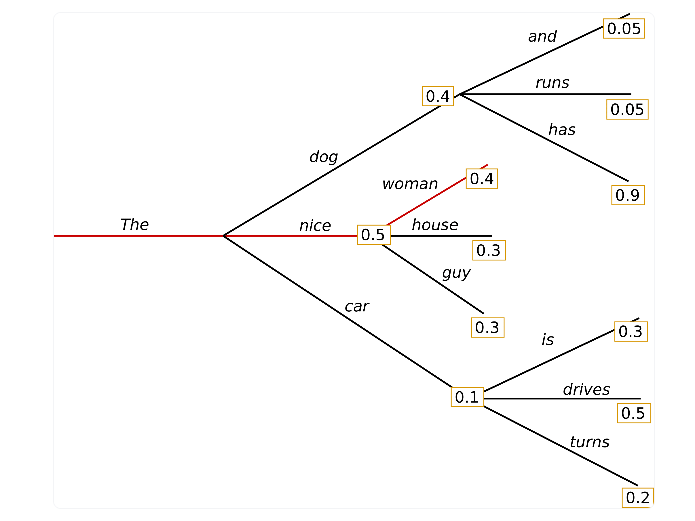

Starting from the word \text{"The"},"The", the algorithm greedily chooses the next word of highest probability \text{"nice"}"nice" and so on, so that the final generated word sequence is (\text{"The"}, \text{"nice"}, \text{"woman"})("The","nice","woman") having an overall probability of 0.5 \times 0.4 = 0.20.5×0.4=0.2 .

In the following we will generate word sequences using GPT2 on the context (\text{"I"}, \text{"enjoy"}, \text{"walking"}, \text{"with"}, \text{"my"}, \text{"cute"}, \text{"dog"})("I","enjoy","walking","with","my","cute","dog"). Let's see how greedy search can be used in transformers:

In [ ]:
# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='tf')

# generate text until the output length (which includes the context length) reaches 50
greedy_output = model.generate(input_ids, max_length=50)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with my dog. I'm not sure if I'll ever be able to walk with my dog.

I'm not sure if I'll


Alright! We have generated our first short text with GPT2 😊. The generated words following the context are reasonable, but the model quickly starts repeating itself! This is a very common problem in language generation in general and seems to be even more so in greedy and beam search - check out Vijayakumar et al., 2016 and Shao et al., 2017.

The major drawback of greedy search though is that it misses high probability words hidden behind a low probability word as can be seen in our sketch above:

The word \text{"has"}"has" with its high conditional probability of 0.90.9 is hidden behind the word \text{"dog"}"dog", which has only the second-highest conditional probability, so that greedy search misses the word sequence \text{"The"}, \text{"dog"}, \text{"has"}"The","dog","has" .

Thankfully, we have beam search to alleviate this problem!

###Beam search
___________

Beam search reduces the risk of missing hidden high probability word sequences by keeping the most likely num_beams of hypotheses at each time step and eventually choosing the hypothesis that has the overall highest probability. Let's illustrate with num_beams=2:

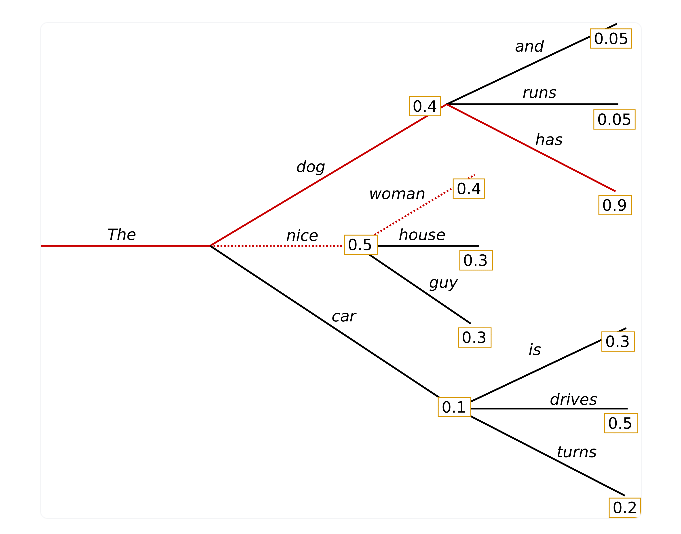

At time step 1, besides the most likely hypothesis (\text{"The"}, \text{"nice"})("The","nice"), beam search also keeps track of the second most likely one (\text{"The"}, \text{"dog"})("The","dog"). At time step 2, beam search finds that the word sequence (\text{"The"}, \text{"dog"}, \text{"has"})("The","dog","has"), has with 0.360.36 a higher probability than (\text{"The"}, \text{"nice"}, \text{"woman"})("The","nice","woman"), which has 0.20.2 . Great, it has found the most likely word sequence in our toy example!

Beam search will always find an output sequence with higher probability than greedy search, but is not guaranteed to find the most likely output.

Let's see how beam search can be used in transformers. We set num_beams > 1 and early_stopping=True so that generation is finished when all beam hypotheses reached the EOS token.

#### base

In [ ]:
# activate beam search and early_stopping
beam_output = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I'm not sure if I'll ever be able to walk with him again. I'm not sure if I'll


While the result is arguably more fluent, the output still includes repetitions of the same word sequences.
A simple remedy is to introduce n-grams (a.k.a word sequences of n words) penalties as introduced by Paulus et al. (2017) and Klein et al. (2017). The most common n-grams penalty makes sure that no n-gram appears twice by manually setting the probability of next words that could create an already seen n-gram to 0.

Let's try it out by setting no_repeat_ngram_size=2 so that no 2-gram appears twice:

#### # set no_repeat_ngram_size to 2

In [ ]:
# set no_repeat_ngram_size to 2
beam_output = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    no_repeat_ngram_size=2, 
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I've been thinking about this for a while now, and I think it's time for me to take a break


Nice, that looks much better! We can see that the repetition does not appear anymore. Nevertheless, n-gram penalties have to be used with care. An article generated about the city New York should not use a 2-gram penalty or otherwise, the name of the city would only appear once in the whole text!

Another important feature about beam search is that we can compare the top beams after generation and choose the generated beam that fits our purpose best.

In transformers, we simply set the parameter num_return_sequences to the number of highest scoring beams that should be returned. Make sure though that num_return_sequences <= num_beams!

#### set return_num_sequences > 1

In [ ]:
# set return_num_sequences > 1
beam_outputs = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    no_repeat_ngram_size=2, 
    num_return_sequences=5, 
    early_stopping=True
)

# now we have 3 output sequences
print("Output:\n" + 100 * '-')
for i, beam_output in enumerate(beam_outputs):
  print("{}: {}".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I've been thinking about this for a while now, and I think it's time for me to take a break
1: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I've been thinking about this for a while now, and I think it's time for me to get back to
2: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with her again.

I've been thinking about this for a while now, and I think it's time for me to take a break
3: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with her again.

I've been thinking about this for a while now, and I think it's time for me to get back to
4: I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I've been thinking about 

As can be seen, the five beam hypotheses are only marginally different to each other - which should not be too surprising when using only 5 beams.

In open-ended generation, a couple of reasons have recently been brought forward why beam search might not be the best possible option:

Beam search can work very well in tasks where the length of the desired generation is more or less predictable as in machine translation or summarization - see Murray et al. (2018) and Yang et al. (2018). But this is not the case for open-ended generation where the desired output length can vary greatly, e.g. dialog and story generation.

We have seen that beam search heavily suffers from repetitive generation. This is especially hard to control with n-gram- or other penalties in story generation since finding a good trade-off between forced "no-repetition" and repeating cycles of identical n-grams requires a lot of finetuning.

As argued in Ari Holtzman et al. (2019), high quality human language does not follow a distribution of high probability next words. In other words, as humans, we want generated text to surprise us and not to be boring/predictable. The authors show this nicely by plotting the probability, a model would give to human text vs. what beam search does.

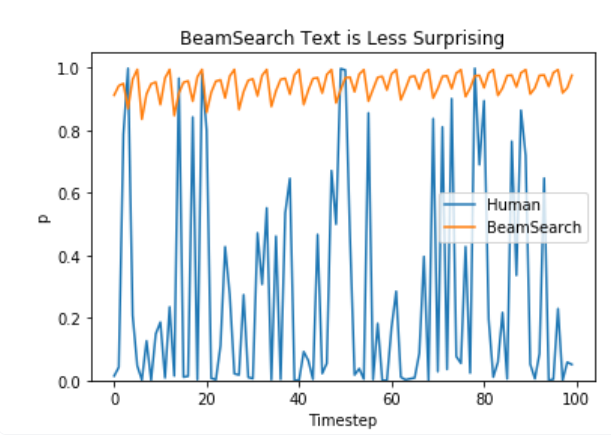

So let's stop being boring and introduce some randomness 🤪.

## Sampling


In its most basic form, sampling means randomly picking the next word w_tw 
t
​
  according to its conditional probability distribution:

w_t \sim P(w|w_{1:t-1})
w 
t
​
 ∼P(w∣w 
1:t−1
​
 )

Taking the example from above, the following graphic visualizes language generation when sampling.

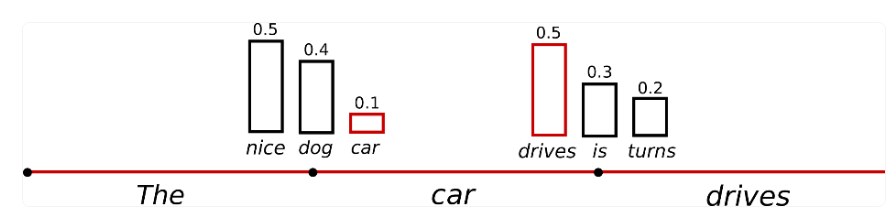

t becomes obvious that language generation using sampling is not deterministic anymore. The word (\text{"car"})("car") is sampled from the conditioned probability distribution P(w | \text{"The"})P(w∣"The"), followed by sampling (\text{"drives"})("drives") from P(w | \text{"The"}, \text{"car"})P(w∣"The","car") .

In transformers, we set do_sample=True and deactivate Top-K sampling (more on this later) via top_k=0. In the following, we will fix random_seed=0 for illustration purposes. Feel free to change the random_seed to play around with the model.

#### base

In [ ]:
# set seed to reproduce results. Feel free to change the seed though to get different results
for seed in [0,100,2733]:
    print("seed:", seed)
    tf.random.set_seed(seed)

    # activate sampling and deactivate top_k by setting top_k sampling to 0
    sample_output = model.generate(
        input_ids, 
        do_sample=True, 
        max_length=50, 
        top_k=0
    )

    print("Output:\n" + 100 * '-')
    print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

seed: 0
Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog but for some reason we both seem to hate them so much because don't they sometimes seem utterly, completely like me・"My house grows up" It was like nothing had ever happened there then - lack of
seed: 100
Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog but maybe by then mall-people that too would not think a CAT-sized dog was appropriate already can easily cover up the major flaw. Please let me know if which you like how cat friend looks like with
seed: 2733
Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog April Adams, our hubby has been to Athens five times, helping her surf on the internet, and using Surfing RIPo to set up a'showroom' for customers.

He

Interesting! The text seems alright - but when taking a closer look, it is not very coherent. the 3-grams new hand sense and local batte harness are very weird and don't sound like they were written by a human. That is the big problem when sampling word sequences: The models often generate incoherent gibberish, cf. Ari Holtzman et al. (2019).

A trick is to make the distribution P(w|w_{1:t-1})P(w∣w 
1:t−1
​
 ) sharper (increasing the likelihood of high probability words and decreasing the likelihood of low probability words) by lowering the so-called temperature of the softmax.

An illustration of applying temperature to our example from above could look as follows.

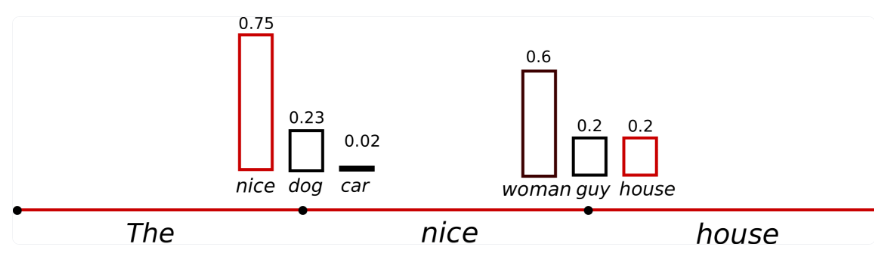

The conditional next word distribution of step t=1t=1 becomes much sharper leaving almost no chance for word (\text{"car"})("car") to be selected.

Let's see how we can cool down the distribution in the library by setting temperature=0.7:

#### temperature (softmax)

In [ ]:
# set seed to reproduce results. Feel free to change the seed though to get different results
tf.random.set_seed(0)
for t in [0.2, 0.7,1.3, 3.0, 7.0]:
    print('temperature:', t)
    # use temperature to decrease the sensitivity to low probability candidates
    sample_output = model.generate(
        input_ids, 
        do_sample=True, 
        max_length=50, 
        top_k=0, 
        temperature=t
    )

    print("Output:\n" + 100 * '-')
    print(tokenizer.decode(sample_output[0], skip_special_tokens=True))
    print()

temperature: 0.2
Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I'm a little worried about my dog, but I'm not sure if I'll ever be able to walk

temperature: 0.7
Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog for a while and in the evenings I play a game. It's fun having my dog but also having a good time. After school, I write and write and write and write. It takes a long time

temperature: 1.3
Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog while recognizing tourists from part parks like Forbidden Zoo, Saikote, Shah Kotcyan Kyla, Stead End port Lux movie about research in spaceships. Owning his cauliflower ball anchored me quickly.

tempera

OK. There are less weird n-grams and the output is a bit more coherent now! While applying temperature can make a distribution less random, in its limit, when setting temperature \to 0→0, temperature scaled sampling becomes equal to greedy decoding and will suffer from the same problems as before

####Top-K Sampling
Fan et. al (2018) introduced a simple, but very powerful sampling scheme, called Top-K sampling. In Top-K sampling, the K most likely next words are filtered and the probability mass is redistributed among only those K next words. GPT2 adopted this sampling scheme, which was one of the reasons for its success in story generation.

We extend the range of words used for both sampling steps in the example above from 3 words to 10 words to better illustrate Top-K sampling.

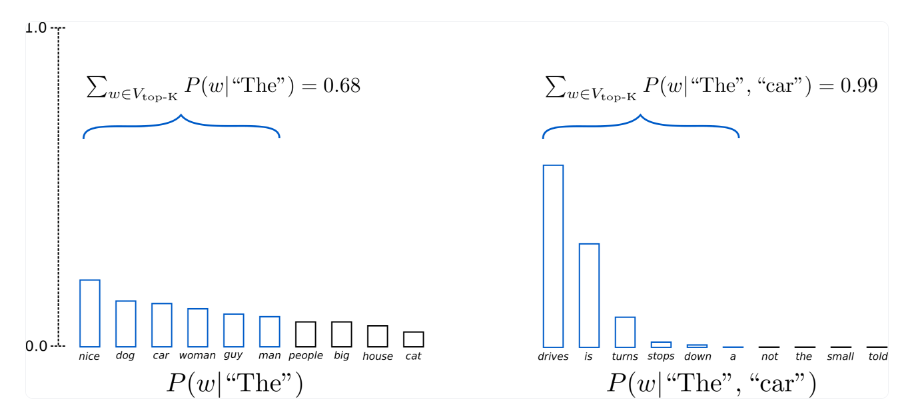

Having set K = 6K=6, in both sampling steps we limit our sampling pool to 6 words. While the 6 most likely words, defined as V_{\text{top-K}}V 
top-K
​
  encompass only ca. two-thirds of the whole probability mass in the first step, it includes almost all of the probability mass in the second step. Nevertheless, we see that it successfully eliminates the rather weird candidates (\text{``not"}, \text{``the"}, \text{``small"}, \text{``told"})(“not",“the",“small",“told") in the second sampling step.

Let's see how Top-K can be used in the library by setting top_k=50:

In [ ]:
# set seed to reproduce results. Feel free to change the seed though to get different results
tf.random.set_seed(0)
# set top_k to 50
for top_k in [50, 20, 6, 1]: 
    print('top_k:', top_k)
    sample_output = model.generate(
        input_ids, 
        do_sample=True, 
        max_length=50, 
        top_k=top_k
    )

    print("Output:\n" + 100 * '-')
    print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

top_k: 50
Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I also love taking care of him as much as any mother does when she visits. She was my little brother and I was a big fan. She is such a sweet and caring person. All of
top_k: 20
Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, so when you see me I'm just gonna put something on the side.

I love that I can look at my dog and smile at her as if I'm her pet.

I love
top_k: 6
Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog and I have a good time."

"I love to play in the woods with my dog, and he is always around. It is a very good time to be a part of your family, as
top_k: 1
Output:
-------------------------------------------------------------------

Not bad at all! The text is arguably the most human-sounding text so far. One concern though with Top-K sampling is that it does not dynamically adapt the number of words that are filtered from the next word probability distribution P(w|w_{1:t-1})P(w∣w 
1:t−1
​
 ). This can be problematic as some words might be sampled from a very sharp distribution (distribution on the right in the graph above), whereas others from a much more flat distribution (distribution on the left in the graph above).

In step t=1t=1, Top-K eliminates the possibility to sample (\text{"people"}, \text{"big"}, \text{"house"}, \text{"cat"})("people","big","house","cat"), which seem like reasonable candidates. On the other hand, in step t=2t=2 the method includes the arguably ill-fitted words (\text{"down"}, \text{"a"})("down","a") in the sample pool of words. Thus, limiting the sample pool to a fixed size K could endanger the model to produce gibberish for sharp distributions and limit the model's creativity for flat distribution. This intuition led Ari Holtzman et al. (2019) to create Top-p- or nucleus-sampling.

#### Top-P (nucleus) sampling
Instead of sampling only from the most likely K words, in Top-p sampling chooses from the smallest possible set of words whose cumulative probability exceeds the probability p. The probability mass is then redistributed among this set of words. This way, the size of the set of words (a.k.a the number of words in the set) can dynamically increase and decrease according to the next word's probability distribution. Ok, that was very wordy, let's visualize.

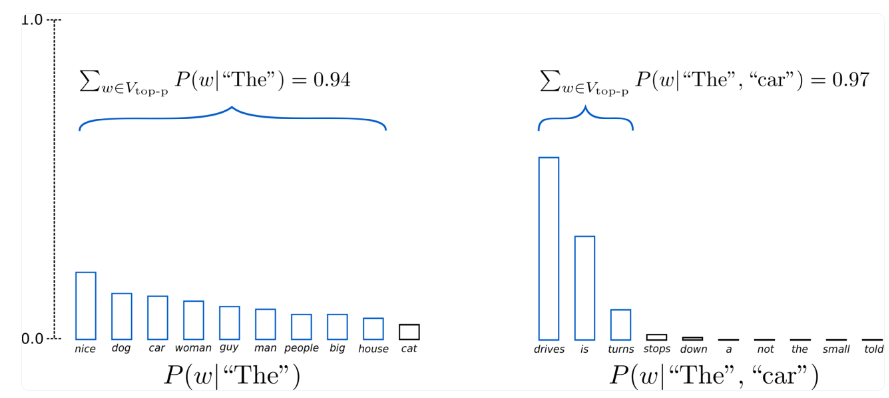

Having set p=0.92p=0.92, Top-p sampling picks the minimum number of words to exceed together p=92\%p=92% of the probability mass, defined as V_{\text{top-p}}V 
top-p
​
 . In the first example, this included the 9 most likely words, whereas it only has to pick the top 3 words in the second example to exceed 92%. Quite simple actually! It can be seen that it keeps a wide range of words where the next word is arguably less predictable, e.g. P(w | \text{"The''})P(w∣"The”), and only a few words when the next word seems more predictable, e.g. P(w | \text{"The"}, \text{"car"})P(w∣"The","car").

Alright, time to check it out in transformers! We activate Top-p sampling by setting 0 < top_p < 1:

In [ ]:
# set seed to reproduce results. Feel free to change the seed though to get different results
tf.random.set_seed(0)
for top_p in [0.9, 0.5, 0.2]:
    print("top_p:", top_p)
    # deactivate top_k sampling and sample only from 92% most likely words
    sample_output = model.generate(
        input_ids, 
        do_sample=True, 
        max_length=50, 
        top_p=top_p, 
        top_k=0
    )

    print("Output:\n" + 100 * '-')
    print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

top_p: 0.9
Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog and we walk along the sidewalk while walking. It's a perfect visit to me!"

I had 2 birthday cookies, vanilla & sesame lollipops. They weren't exactly cute but they were
top_p: 0.5
Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog and talking to my mom about what she does. I have an excellent relationship with my dogs and have been very happy with them.

When I was in middle school, my best friend and I got together
top_p: 0.2
Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, and I'm always happy to see him around. I'm not sure if he's going to be able to walk, but I'm sure he'll be able to walk. I'm not sure if he


Great, that sounds like it could have been written by a human. Well, maybe not quite yet.

While in theory, Top-p seems more elegant than Top-K, both methods work well in practice. Top-p can also be used in combination with Top-K, which can avoid very low ranked words while allowing for some dynamic selection.

Finally, to get multiple independently sampled outputs, we can again set the parameter num_return_sequences > 1:

#### Mix Sampling Top-K, Top-P, num_return_sequences>1

In [ ]:
# set seed to reproduce results. Feel free to change the seed though to get different results
tf.random.set_seed(0)

# set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
sample_outputs = model.generate(
    input_ids,
    do_sample=True, 
    max_length=50, 
    top_k=50, 
    top_p=0.95, 
    num_return_sequences=3
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: I enjoy walking with my cute dog. He has my back to him too and I love sitting around his and watching.

So I'm pretty sure that this post may have been of interest to you but I don't think we have much
1: I enjoy walking with my cute dog, I love having my dog, I like seeing my dog, I'm a wonderful owner.

I think I'm going to spend a little more time with her. I'm very fortunate to have her
2: I enjoy walking with my cute dog and I'll spend my free time doing the occasional yoga or walking around my backyard. I enjoy this activity because it offers a simple yet stimulating experience in one of the most intimate environments available in the whole world.


Cool, now you should have all the tools to let your model write your stories with transformers!

Conclusion
As ad-hoc decoding methods, top-p and top-K sampling seem to produce more fluent text than traditional greedy - and beam search on open-ended language generation. Recently, there has been more evidence though that the apparent flaws of greedy and beam search - mainly generating repetitive word sequences - are caused by the model (especially the way the model is trained), rather than the decoding method, cf. Welleck et al. (2019). Also, as demonstrated in Welleck et al. (2020), it looks as top-K and top-p sampling also suffer from generating repetitive word sequences.

In Welleck et al. (2019), the authors show that according to human evaluations, beam search can generate more fluent text than Top-p sampling, when adapting the model's training objective.

Open-ended language generation is a rapidly evolving field of research and as it is often the case there is no one-size-fits-all method here, so one has to see what works best in one's specific use case.

Good thing, that you can try out all the different decoding methods in transfomers 🤗.

That was a short introduction on how to use different decoding methods in transformers and recent trends in open-ended language generation.

Feedback and questions are very welcome on the Github repository.

For more fun generating stories, please take a look at Writing with Transformers

Thanks to everybody, who has contributed to the blog post: Alexander Rush, Julien Chaumand, Thomas Wolf, Victor Sanh, Sam Shleifer, Clément Delangue, Yacine Jernite, Oliver Åstrand and John de Wasseige.

Appendix
There are a couple of additional parameters for the generate method that were not mentioned above. We will explain them here briefly!

min_length can be used to force the model to not produce an EOS token (= not finish the sentence) before min_length is reached. This is used quite frequently in summarization, but can be useful in general if the user wants to have longer outputs.

repetition_penalty can be used to penalize words that were already generated or belong to the context. It was first introduced by Keskar et al. (2019) and is also used in the training objective in Welleck et al. (2019). It can be quite effective at preventing repetitions, but seems to be very sensitive to different models and use cases, e.g. see this discussion on Github.

attention_mask can be used to mask padded tokens

pad_token_id, bos_token_id, eos_token_id: If the model does not have those tokens by default, the user can manually choose other token ids to represent them.

For more information please also look into the generate function docstring.

### example Top-K Top-P sampling implementation
https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
https://programmersought.com/article/42077545764/


In [ ]:
# The code input is logits, and the consideration is very thorough (I feel that I missed the consideration of both k and p, which should be inappropriate)
# Clever use of torch.cumsum
# Avoid the embarrassing situation where you can't choose a word
def top_k_top_p_filtering(logits, top_k=0, top_p=1.0, filter_value=-float("Inf"), min_tokens_to_keep=1):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (batch size, vocabulary size)
            if top_k > 0: keep only top k tokens with highest probability (top-k filtering).
            if top_p < 1.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
            Make sure we keep at least min_tokens_to_keep per batch example in the output
        From: https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
    """
    if top_k > 0:
        top_k = min(max(top_k, min_tokens_to_keep), logits.size(-1))  # Safety check
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold (token with 0 are kept)
        sorted_indices_to_remove = cumulative_probs > top_p
        if min_tokens_to_keep > 1:
            # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
            sorted_indices_to_remove[..., :min_tokens_to_keep] = 0
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        # scatter sorted tensors to original indexing
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = filter_value
    return logits

In [ ]:
#Look at repeated punishment

# The input is also logits (lprobs)
# At the same time input the words that appeared before and the penalty coefficient (greater than 1)
# Taking into account that logit is positive and negative, the processing method should be different
def enforce_repetition_penalty_(self, lprobs, batch_size, num_beams, prev_output_tokens, repetition_penalty):
    """repetition penalty (from CTRL paper https://arxiv.org/abs/1909.05858). """
    for i in range(batch_size * num_beams):
        for previous_token in set(prev_output_tokens[i].tolist()):
            # if score < 0 then repetition penalty has to multiplied to reduce the previous token probability
            if lprobs[i, previous_token] < 0:
                lprobs[i, previous_token] *= repetition_penalty
            else:
                lprobs[i, previous_token] /= repetition_penalty

In [ ]:
# The last is repeated word removal

# This function will return an unusable vocabulary
# You can learn from the clever way to generate n-gram
# Below is a 3-gram example
# a = [1,2,3,4,5]
# for ngram in zip(*[a[i:] for i in range(3)]):
#    print(ngram)
def calc_banned_tokens(prev_input_ids, num_hypos, no_repeat_ngram_size, cur_len):
    # Copied from fairseq for no_repeat_ngram in beam_search"""
    if cur_len + 1 < no_repeat_ngram_size:
        # return no banned tokens if we haven't generated no_repeat_ngram_size tokens yet
        return [[] for _ in range(num_hypos)]
    generated_ngrams = [{} for _ in range(num_hypos)]
    for idx in range(num_hypos):
        gen_tokens = prev_input_ids[idx].numpy().tolist()
        generated_ngram = generated_ngrams[idx]
        # Is this clever sentence
        for ngram in zip(*[gen_tokens[i:] for i in range(no_repeat_ngram_size)]):
            prev_ngram_tuple = tuple(ngram[:-1])
            generated_ngram[prev_ngram_tuple] = generated_ngram.get(prev_ngram_tuple, []) + [ngram[-1]]

    def _get_generated_ngrams(hypo_idx):
        # Before decoding the next token, prevent decoding of ngrams that have already appeared
        start_idx = cur_len + 1 - no_repeat_ngram_size
        ngram_idx = tuple(prev_input_ids[hypo_idx, start_idx:cur_len].numpy().tolist())
        return generated_ngrams[hypo_idx].get(ngram_idx, [])

    banned_tokens = [_get_generated_ngrams(hypo_idx) for hypo_idx in range(num_hypos)]
    return banned_tokens

In [ ]:
import math
math.log(10), math.log(0.1), math.log(1)

(2.302585092994046, -2.3025850929940455, 0.0)

In [ ]:
do_sample = True
if do_sample:
    # This is the sampling method today
    _scores = scores + beam_scores[:, None].expand_as(scores)  # (batch_size * num_beams, vocab_size)
    # Top-p/top-k filtering, this step reconstructs the candidate set
    _scores = top_k_top_p_filtering(
        _scores, top_k=top_k, top_p=top_p, min_tokens_to_keep=2
    )  # (batch_size * num_beams, vocab_size)
    # re-organize to group the beam together to sample from all beam_idxs
    _scores = _scores.contiguous().view(
        batch_size, num_beams * vocab_size
    )  # (batch_size, num_beams * vocab_size)

    # Sample 2 next tokens for each beam (so we have some spare tokens and match output of greedy beam search)
    probs = F.softmax(_scores, dim=-1)
    # Sampling
    next_tokens = torch.multinomial(probs, num_samples=2 * num_beams)  # (batch_size, num_beams * 2)
    # Compute next scores
    next_scores = torch.gather(_scores, -1, next_tokens)  # (batch_size, num_beams * 2)
    # sort the sampled vector to make sure that the first num_beams samples are the best
    next_scores, next_scores_indices = torch.sort(next_scores, descending=True, dim=1)
    next_tokens = torch.gather(next_tokens, -1, next_scores_indices)  # (batch_size, num_beams * 2)
else:
    # This is yesterday's beam search method
    # Directly add log probability to find conditional probability
    next_scores = scores + beam_scores[:, None].expand_as(scores)  # (batch_size * num_beams, vocab_size)

    # re-organize to group the beam together (we are keeping top hypothesis accross beams)
    next_scores = next_scores.view(
        batch_size, num_beams * vocab_size
    )  # (batch_size, num_beams * vocab_size)

    next_scores, next_tokens = torch.topk(next_scores, 2 * num_beams, dim=1, largest=True, sorted=True)